<a href="https://colab.research.google.com/github/MANISH007700/PyTorch_Lightning_Learning/blob/master/Tutorial_2_Intro_to_Activation_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependencies and packages

In [2]:
# ! pip install --quiet "torchmetrics>=0.3" "torch>=1.6, <1.9" "pytorch-lightning>=1.3" "torchvision" "seaborn" "matplotlib"

## Import libs and pkges

In [3]:
import os
import json
import math 
import urllib.request 
from urllib.error import HTTPError
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sb 

import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.utils.data as data 
import torch.optim as optim 
import torchvision
from torchvision import transforms 
from torchvision.datasets import FashionMNIST 
from tqdm.notebook import tqdm 

%matplotlib inline 
from IPython.display import set_matplotlib_formats 
set_matplotlib_formats("svg", "pdf") # for exports 
sb.set()


In [4]:
# make dataset folders and checkpoint folders 
# dataset - store data
# checkpoint - store trained model and weights 

DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# print(DATASET_PATH) 
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINTS", "saved_models/activation_function/")
# print(CHECKPOINT_PATH)

In [5]:
# function for setting sead for reproducibility
def set_seed(seed):
  np.random.seed(seed)    # setting seed for numpy 
  torch.manual_seed(seed) # for torch 
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(84)

# deterministic is important for reproducibility
# benchmark set to False and deterministic set to True 
torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False 

# fetch the device 
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")
print(device)

cuda


## Download Model and pretrained files 

In [6]:
#github url where all the models is saved 
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial3/"
# files to download 
pretrained_files = [
    "FashionMNIST_relu.config",
    "FashionMNIST_relu.tar",
    "FashionMNIST_sigmoid.config",
    "FashionMNIST_sigmoid.tar",
    "FashionMNIST_tanh.config",
    "FashionMNIST_tanh.tar"
]

# create checkpoint path, if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok = True)

# for each model, try downloading it if not present 
for filename in pretrained_files:
  filepath = os.path.join(CHECKPOINT_PATH, filename)
  if not os.path.isfile(filepath):
    file_url = base_url + filename 
    print("Downloading {file}", filename)
    try:
      # download file and store in file path
      urllib.request.urlretrieve(file_url, filepath)
    except HTTPError as e:
      print("Something went wrong with the provided link, please check again or manually download files from github")


## Common Activation Function

In [7]:
# let' try building our own activation fn
# we can already use from torch.nn too, 
'''
nn.Sigmoid, nn.Tanh work as a module 
torch.sigmoid, torch.tanh work as function
'''

class ActivationFunction(nn.Module):
  def __init__(self):
    super().__init__()

    self.name = self.__class__.__name__ 
    self.config = {"name": self.name}
  

In [8]:
# let's implement sigmoid and tanh and relu
class Sigmoid(ActivationFunction):
  def forward(self, x):
    return 1 / (1 + torch.exp(-x))
    # return 1 / (1 + torch.exp(-x))

class Tanh(ActivationFunction):
  def forward(self, x):
    x_exp, neg_x_exp = torch.exp(x), torch.exp(-x)
    return (x_exp - neg_x_exp) / (x_exp + neg_x_exp)

class ReLU(ActivationFunction):
  def forward(self, x):
    return x*(x > 0).float()

In [9]:
# store in dict 
act_fn_by_name = {
    "sigmoid": Sigmoid, 
    "tanh": Tanh, 
    "relu": ReLU
}

In [10]:
# let's visualize act fn. You need all 3, input, act output and act gradient
def get_grads(act, x):
  # make a clone 
  x = x.clone().requires_grad_()
  out = act(x)            # finding output from act
  out.sum().backward()    # summing grad
  return x.grad 



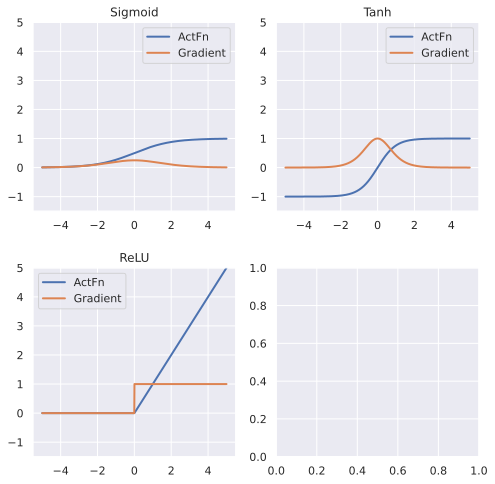

In [11]:
# visualize now 
def viz_act_fn(act_fn, x, ax):
  y = act_fn(x)    
  y_grads = get_grads(act_fn, x)
  x, y, y_grads = x.cpu().numpy(), y.cpu().numpy(), y_grads.cpu().numpy()

  ax.plot(x, y, linewidth=2, label = "ActFn")
  ax.plot(x, y_grads, linewidth=2, label = "Gradient")
  ax.set_title(act_fn.name)
  ax.legend()
  ax.set_ylim(-1.5, x.max())


act_fns = [act_fn() for act_fn in act_fn_by_name.values()]
x = torch.linspace(-5, 5, 1000)  # Range on which we want to visualize the activation functions
# Plotting
cols = 2
rows = math.ceil(len(act_fns) / float(cols))
fig, ax = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
for i, act_fn in enumerate(act_fns):
    viz_act_fn(act_fn, x, ax[divmod(i, cols)])
fig.subplots_adjust(hspace=0.3)
plt.show()


## Let's Create the Model for FashionMNIST

In [35]:
class FashionMNISTNetwork(nn.Module):
  # 28*28 image 
  # 10 classes 
  def __init__(self, act_fn, x=None, num_inputs = 784, num_hidden_1 = 256, num_hidden_2 = 128, num_hidden_3 = 64, num_outputs = 10):
    super().__init__()

    self.linear1 = nn.Linear(num_inputs, num_hidden_1)
    self.act1 = act_fn()
    self.linear2 = nn.Linear(num_hidden_1, num_hidden_2)
    self.act2 = act_fn()
    self.linear3 = nn.Linear(num_hidden_2, num_hidden_3)
    self.act3 = act_fn()
    self.linear4 = nn.Linear(num_hidden_3, num_outputs)
    
    # save all hyper params 
    self.config ={
        "act_fn": act_fn().config, 
        "input_size": num_inputs, 
        "hidden_size": [num_hidden_1, num_hidden_2, num_hidden_3], 
        "output_size": num_outputs
    }
  
  def forward(self, x):
    # reshape first
    # need 1 column only, decide how much row should be given 
    x = x.view(-1, 1)
    x = self.linear1(x)
    x = self.act1(x)
    x = self.linear2(x)
    x = self.act2(x)
    x = self.linear3(x)
    x = self.act3(x)
    x = self.linear4(x)
    return x



In [36]:
for key, value in act_fn_by_name.items():

  model = FashionMNISTNetwork(value)
  for name, param in model.named_parameters():
    print("Name {0}, Param {1}".format(name, param))
    print(model)
  break

Name linear1.weight, Param Parameter containing:
tensor([[-0.0021, -0.0067, -0.0189,  ..., -0.0307, -0.0276, -0.0291],
        [-0.0013, -0.0151, -0.0053,  ..., -0.0339,  0.0081,  0.0091],
        [-0.0107,  0.0291, -0.0106,  ...,  0.0153, -0.0352,  0.0286],
        ...,
        [-0.0349, -0.0006,  0.0113,  ..., -0.0287,  0.0326,  0.0246],
        [-0.0170, -0.0216, -0.0355,  ..., -0.0100, -0.0306, -0.0158],
        [-0.0082, -0.0302, -0.0262,  ..., -0.0135,  0.0037, -0.0044]],
       requires_grad=True)
FashionMNISTNetwork(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (act1): Sigmoid()
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (act2): Sigmoid()
  (linear3): Linear(in_features=128, out_features=64, bias=True)
  (act3): Sigmoid()
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)
Name linear1.bias, Param Parameter containing:
tensor([-0.0320, -0.0181, -0.0257, -0.0159, -0.0106, -0.0173,  0.0174,  0.0325,
        -0.0100, -0

# Let's load the dataset

In [14]:
# first normalize the image and then use transforms
# apply on both test and train data 
transforms = transforms.Compose(
    [
     transforms.ToTensor(), 
     transforms.Normalize((0.5,), (0.5,))
    ]
)

In [15]:
train_dataset = FashionMNIST(root = DATASET_PATH, train = True, transform = transforms, download = True)
test_dataset = FashionMNIST(root = DATASET_PATH, train = False, transform = transforms, download = True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [16]:
train_dataset, len(train_dataset)

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5,), std=(0.5,))
            ), 60000)

In [17]:
train_set

## Make Train, Baland Test Data Loader


In [37]:
train_loader = data.DataLoader(train_set, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, drop_last = False)
val_loader = data.DataLoader(val_set, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, drop_last = False)
test_loader = data.DataLoader(test_dataset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, drop_last = False)


In [38]:
img, label = next(iter(train_loader))
print(img[6].shape, label.shape)

torch.Size([1, 28, 28]) torch.Size([64])


In [39]:
m = img[11]
g = m.reshape(m.shape[1], m.shape[2])
g.shape

torch.Size([28, 28])

tensor(1)


(<matplotlib.image.AxesImage at 0x7f80d7081ad0>, None)

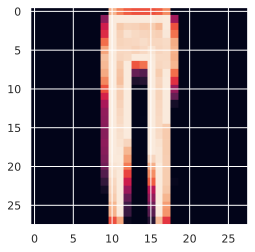

In [40]:
plt.imshow(g), print(label[11])

# Visualizing Gradient before and After training the model

In [41]:
def visualize_gradient(net, color = "C0"):
  '''
  net - object of model class FashionMNISTModel 
  color - color of gradient 
  ''' 
  net.to(device)
  net.eval()

  # pass 1 batch and see the gradient 
  small_loader = data.DataLoader(train_set, batch_size = 256, shuffle = False)
  imgs, labels = next(iter(small_loader))
  imgs, labels = imgs.to(device), labels.to(device)

  net.zero_grad()
  pred = net(imgs)
  loss = F.cross_entropy(pred, labels)
  loss.backward()

  # use only weight params 
  grads = {
      name: params.grad.data.view(-1).cpu().clone().numpy() for name, params in net.named_parameters() if "weight" in name 
  }
  net.zero_grad()

  # Plotting
  columns = len(grads)
  fig, ax = plt.subplots(1, columns, figsize=(columns * 3.5, 2.5))
  fig_index = 0
  for key in grads:
      key_ax = ax[fig_index % columns]
      sb.histplot(data=grads[key], bins=30, ax=key_ax, color=color, kde=True)
      key_ax.set_title(str(key))
      key_ax.set_xlabel("Grad magnitude")
      fig_index += 1
  fig.suptitle(
      f"Gradient magnitude distribution for activation function {net.config['act_fn']['name']}", fontsize=14, y=1.05
  )
  fig.subplots_adjust(wspace=0.45)
  plt.show()
  plt.close()


In [44]:
# Seaborn prints warnings if histogram has small values. We can ignore them for now
warnings.filterwarnings("ignore")
# Create a plot for every activation function
for i, act_fn_name in enumerate(act_fn_by_name):
    # Setting the seed ensures that we have the same weight initialization for each activation function
    set_seed(42)
    act_fn = act_fn_by_name[act_fn_name]()
    net_actfn = FashionMNISTNetwork(act_fn, x=2).to(device)
    visualize_gradient(net_actfn, color=f"C{i}")


TypeError: ignored